In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from physics.models.battery import battery_model, battery_config, BatteryModel, BatteryModelConfig

data = np.load('data.npz')
U_measured = data['voltage']  # Replace with the correct key for measured voltages
power = np.array(data['power'], dtype=np.float64)
soc_measured = data['soc']

# Calculate current if the dataset contains power and voltage
I_load = power / U_measured  # Ensure U_measured has no zeros to avoid division errors
N = len(U_measured)  # Number of data points


In [12]:
def objective(params):
    battery_config = BatteryModelConfig(
    R_0_data=params[:5],
    R_P=params[5],
    C_P=params[6],
    Q_total=259200,
    SOC_data=params[7:12],
    Uoc_data=params[12:17],
    max_current_capacity=40.0,
    max_energy_capacity=500.0
)
    bm = BatteryModel(battery_config)

    # Call update_array to get terminal voltage (U_L) and SOC
    soc_array, U_predicted = bm.update_array(power, 1, rust=True)

    # Compute mean squared error
    error = np.mean((U_measured - U_predicted)**2)
    return error

In [20]:
initial_guess = [0.002, 0.0025, 0.0023, 0.0025, 0.003, #R_0
                 0.0001, 13000, # R_P, C_P
                 0.08, 0.1, 0.2, 0.3, 0.4,  #SOC
                 3.1,3.2,3.3,3.4,3.5]  #Uoc
result = minimize(objective, initial_guess, method='BFGS')

optimized_params = result.x

# Display the results without scientific notation
print("Optimized Parameters:")
print(", ".join([f"{x:.6f}" for x in optimized_params]))

# # Optimize using scipy's minimize
# popt, pcov = curve_fit(objective, power, soc_measured, initial_guess, maxfev=10000)
#
# print(pcov.diagonal())

# Extract optimized parameters
#params = result.x

#print(f"Optimized Parameters: {[f'{x:.4f}' for x in params]}")


Optimized Parameters:
0.004632, -0.001268, 0.004406, 0.001855, 0.002679, 0.000091, 13000.000000, -0.660990, 0.765248, 0.188998, 0.290056, 0.561627, 3.217874, 3.030698, 3.394991, 3.351363, 3.505192


/Users/fleming/Library/Caches/pypoetry/virtualenvs/data-analysis-VV1WcTYr-py3.12/lib/python3.12/site-packages/physics/models/battery/battery_model.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  self.U_oc_coefficients, _ = optimize.curve_fit(quintic_polynomial, Soc_data, Uoc_data)
/Users/fleming/Library/Caches/pypoetry/virtualenvs/data-analysis-VV1WcTYr-py3.12/lib/python3.12/site-packages/physics/models/battery/battery_model.py:51: OptimizeWarning: Covariance of the parameters could not be estimated
  self.R_0_coefficients, _ = optimize.curve_fit(quintic_polynomial, Soc_data, R_0_data)
/var/folders/81/8nlm6q593ps9_7r34h09zk680000gn/T/ipykernel_25559/3626831866.py:18: RuntimeWarning: overflow encountered in square
  error = np.mean((U_measured - U_predicted)**2)
/Users/fleming/Library/Caches/pypoetry/virtualenvs/data-analysis-VV1WcTYr-py3.12/lib/python3.12/site-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_

/Users/fleming/Library/Caches/pypoetry/virtualenvs/data-analysis-VV1WcTYr-py3.12/lib/python3.12/site-packages/physics/models/battery/battery_model.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  self.U_oc_coefficients, _ = optimize.curve_fit(quintic_polynomial, Soc_data, Uoc_data)
/Users/fleming/Library/Caches/pypoetry/virtualenvs/data-analysis-VV1WcTYr-py3.12/lib/python3.12/site-packages/physics/models/battery/battery_model.py:51: OptimizeWarning: Covariance of the parameters could not be estimated
  self.R_0_coefficients, _ = optimize.curve_fit(quintic_polynomial, Soc_data, R_0_data)


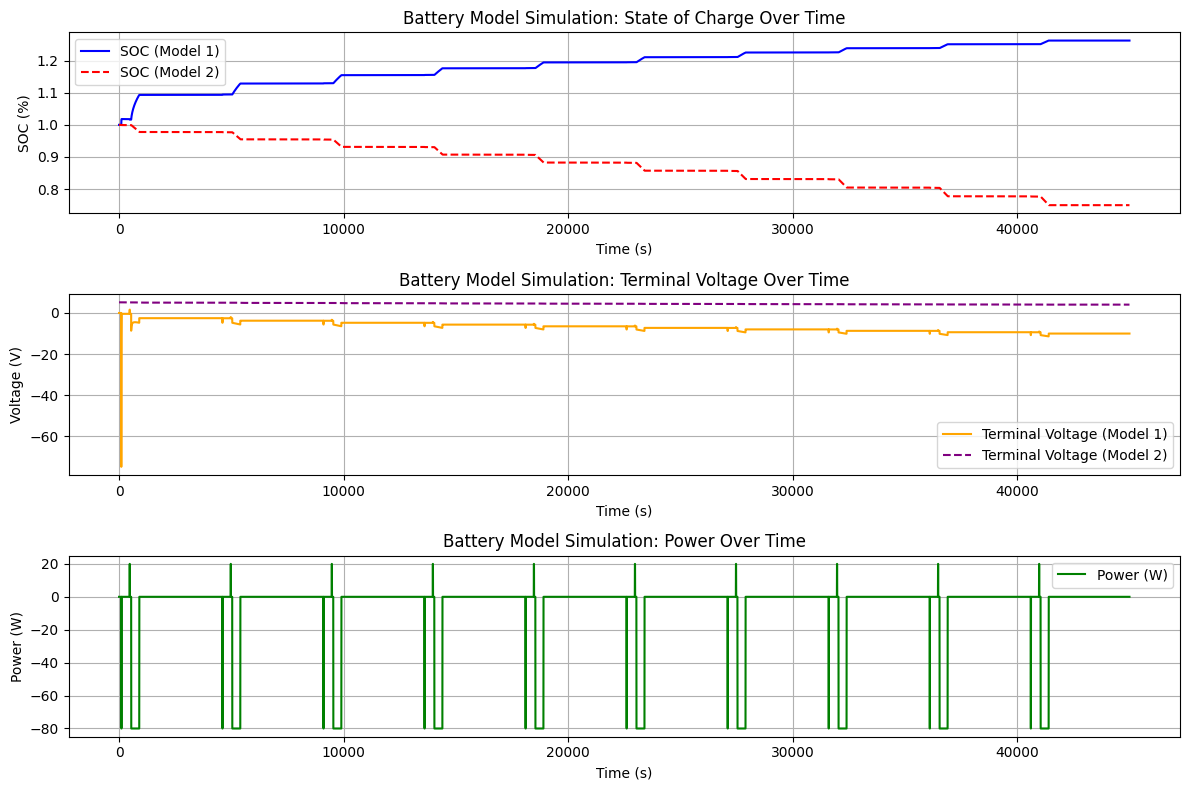

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Define the initial guesses for the first battery model
initial_guess = [
    0.004632, -0.001268, 0.004406, 0.001855, 0.002679,  # R_0
    0.000091, 13000.000000,                              # R_P, C_P
    -0.660990, 0.765248, 0.188998, 0.290056, 0.561627,   # SOC
    3.217874, 3.030698, 3.394991, 3.351363, 3.505192     # Uoc
]


# Define the second (commented-out) parameters
overlay_R_0_data = [0.002564, 0.002541, 0.002541, 0.002558, 0.002549]  # Match length of initial_guess[:5]
overlay_R_P = 0.000530
overlay_C_P = 14646
overlay_SOC_data = [0.0752, 0.1705, 0.2677, 0.366, 0.4654]  # Match length of initial_guess[7:12]
overlay_Uoc_data = [3.481, 3.557, 3.597, 3.623, 3.660]  # Match length of initial_guess[12:17]

# Configure the first battery model
battery_config_1 = BatteryModelConfig(
    R_0_data=initial_guess[:5],
    R_P=initial_guess[5],
    C_P=initial_guess[6],
    Q_total=259200,
    SOC_data=initial_guess[7:12],
    Uoc_data=initial_guess[12:17],
    max_current_capacity=40.0,
    max_energy_capacity=500.0
)

# Configure the second battery model
battery_config_2 = BatteryModelConfig(
    R_0_data=overlay_R_0_data,
    R_P=overlay_R_P,
    C_P=overlay_C_P,
    Q_total=259200,
    SOC_data=overlay_SOC_data,
    Uoc_data=overlay_Uoc_data,
    max_current_capacity=40.0,
    max_energy_capacity=500.0
)

# Instantiate the battery models
battery_model_1 = BatteryModel(battery_config_1)
battery_model_2 = BatteryModel(battery_config_2)

# Simulate the battery behavior for both models
soc_array_1, voltage_array_1 = battery_model_1.update_array(power, tick=1, rust=True)[:2]
soc_array_2, voltage_array_2 = battery_model_2.update_array(power, tick=1, rust=True)[:2]

# Time array for plotting
time = np.arange(len(power))

# Plot the State of Charge (SOC)
plt.figure(figsize=(12, 8))

# State of Charge (SOC)
plt.subplot(3, 1, 1)
plt.plot(time, soc_array_1, label="SOC (Model 1)", color="blue")
plt.plot(time, soc_array_2, label="SOC (Model 2)", color="red", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("SOC (%)")
plt.title("Battery Model Simulation: State of Charge Over Time")
plt.grid(True)
plt.legend()

# Terminal Voltage (U_L)
plt.subplot(3, 1, 2)
plt.plot(time, voltage_array_1, label="Terminal Voltage (Model 1)", color="orange")
plt.plot(time, voltage_array_2, label="Terminal Voltage (Model 2)", color="purple", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Battery Model Simulation: Terminal Voltage Over Time")
plt.grid(True)
plt.legend()

# Power Plot
plt.subplot(3, 1, 3)
plt.plot(time, power, label="Power (W)", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Power (W)")
plt.title("Battery Model Simulation: Power Over Time")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
